In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d
from matplotlib.patches import Arc
from lbow.oneDimensional.steadystate import HalfPlaneModel
from skimage.feature import peak_local_max
from matplotlib.colors import TwoSlopeNorm

In [3]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['axes.titlesize']  = 16

# Produce figure 7 and 9

Produce figures 7 and 9 related to the inclination of the gravity wave field versus Froude number

Copyright 2024 Dries Allaerts

Licensed under the Apache License, Version 2.0.

# Define some functions

In [4]:
def create_model(U,N,L,verbose=0):    
    # Hill shape
    hmax = 0.1*L                     # Height of the hill [m]
    h = lambda x: hmax/(1+(x/L)**2)  # Shape function of the hill
    
    # Numerical parameters
    Lx = 2000 * L                    # Length of the numerical domain [m]
    Nx = 2*int(1e4)                  # Number of grid points
    
    Ls = 2*np.pi*U/N
    Lz = 3.5 * Ls
    Nz = int(3.5 * 60 + 1)
    if verbose>0: print('Number of vertical levels is {} '.format(Nz))
    
    # Numerical grid
    xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
    if verbose>0: print('Horizontal grid resolution is {} m'.format(dx))
        
    zs,dz = np.linspace(0,Lz,Nz,retstep=True)
    if verbose>0: print('Vertical grid resolution is {} m'.format(dz))
    
    return xs,zs,HalfPlaneModel(xs,h(xs),U,N)

In [5]:
def find_peaks(xs, zs, var, threshold_rel=0.5, min_distance=2, exclude_border=True, verbose=0, **kwargs):
    # Use peak_local_max to find coordinates of local extrema
    peak_indices = peak_local_max(np.abs(var.T),
                                  min_distance=min_distance,
                                  threshold_rel=threshold_rel,
                                  exclude_border=exclude_border,
                                  **kwargs)
    
    Npeaks = peak_indices.shape[0]
    # Sort based on z coordinate
    peak_indices = peak_indices[np.argsort(peak_indices[:, 0])]
    # Convert from indices to coordinates
    xp = xs[peak_indices[:,1]]
    zp = zs[peak_indices[:,0]]
    
    
    if verbose>0: print('Number of peaks found is {}'.format(Npeaks))
    if verbose>1:
        print('Peak coordinates:')
        for i in range(Npeaks):
            print(xp[i],zp[i])
    
    return xp, zp

In [6]:
def parabolic_slope_fx(x,z):
    # z = f(x)
    def fit_func(x, a):
        # Curve fitting function
        return a * x**2
    
    # Curve fitting
    params = curve_fit(fit_func, x, z)
    
    return params[0][0]

In [7]:
def parabolic_slope_fz(x,z):
    # x = f(z)
    def fit_func(z, b):
        # Curve fitting function
        return b * np.sqrt(z)
    
    # Curve fitting
    params = curve_fit(fit_func, z, x)
    
    return params[0][0]

In [8]:
def parabolic_slope_fz_2dof(x,z):
    # x = f(z)
    def fit_func(z, b0, b1):
        # Curve fitting function
        return b0 * np.sqrt(z) + b1
    
    # Curve fitting
    params = curve_fit(fit_func, z, x)
    
    return params[0][0], params[0][1]

In [9]:
def parabolic_slope_fz_3dof(x,z):
    # x = f(z)
    def fit_func(z, b0, b1, z0):
        # Curve fitting function
        return b0 * np.sqrt(z-z0) + b1
    
    def jac_func(z,b0,b1,z0):
        # Jacobian of the fitting function
        df_b0 = np.sqrt(z-z0)
        df_b1 = np.ones(z.size)
        df_z0 = - 0.5 * b0 / np.sqrt(z-z0)
        return np.array([df_b0,df_b1,df_z0]).T
    
    #p0 = [10,-200,-50]
    p0 = [0.1,0.1,-0.1]
    # Curve fitting
    try:
        params = curve_fit(fit_func, z, x,
                           bounds=([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,0]),
                           max_nfev=1000*x.size,
                           p0 = p0,
                           #jac = jac_func,
                           verbose=0)
        return params[0][0], params[0][1], params[0][2]
    except RuntimeError:
        return np.nan, np.nan, np.nan

In [10]:
def linear_slope_fx(x0,a):
    # Slope of line tangent to parabola z = a x**2 at x0
    return 2*a*x0

In [11]:
def linear_slope_fz(z0,b):
    # Slope of line tangent to square root function x = b sqrt(z) at z0
    return 0.5 * b / np.sqrt(z0)

In [12]:
def linear_slope_fz_3dof(z,b0,z0):
    # Slope of line tangent to square root function x = b sqrt(z) at z
    return 0.5 * b0 / np.sqrt(z-z0)

In [13]:
def find_inclination_eta(U,N,L,verbose=0):
    Fr = U/N/L
    Ls = 2*np.pi*U/N
    
    # Create model
    xs,zs,model = create_model(U,N,L,verbose)
    
    # Solve for eta
    eta = model.solve('eta',zs,space='real')
    
    # Find extrema in of the 2D contour
    threshold_rel=min(0.6,1/(3.5*Fr))
    exclude_border = True
    
    xp, zp = find_peaks(xs,zs,eta,min_distance=5,
                        threshold_rel=threshold_rel,
                        exclude_border=exclude_border,
                        verbose=verbose)
    
    # Parabolic fit of the extrema
    b = parabolic_slope_fz(xp, zp)
    # Find extremum closest to the arc with radius 9/8*Ls
    R = np.sqrt(xp**2+zp**2)
    idx = (np.abs(R - 9/8*Ls)).argmin()
    # x coordinate of first maximum above ground
    x1 = b*np.sqrt(zp[idx])
    # slope of parabolic fit at x1
    bprime = linear_slope_fz(zp[idx],b)

    # Inclination
    return xp.size, np.arctan2(1,bprime), zp[idx]

In [14]:
def find_inclination_w(U,N,L,verbose=0,z1=None):
    Fr = U/N/L
    Ls = 2*np.pi*U/N
    
    # Create model
    xs,zs,model = create_model(U,N,L,verbose)
    
    # Solve for w
    w = model.solve('w',zs,space='real')
    
    # Find extrema in of the 2D contour
    threshold_rel=min(0.5,1/(6*Fr))
    exclude_border = True
    
    xp, zp = find_peaks(xs,zs,w,min_distance=5,
                        threshold_rel=threshold_rel,
                        exclude_border=exclude_border,
                        verbose=verbose)
    
    # Parabolic fit of the extrema
    b0, b1, z0 = parabolic_slope_fz_3dof(xp, zp)
    if z1 is None:
        # Find extremum closest to the arc with radius 7/8*Ls
        R = np.sqrt(xp**2+zp**2)
        idx = (np.abs(R - 7/8*Ls)).argmin()
        z1 = zp[idx]
    # x coordinate of first maximum above ground
    x1 = b0*np.sqrt(z1-z0)+b1
    # slope of parabolic fit at x1
    bprime = linear_slope_fz_3dof(z1,b0,z0)

    # Inclination
    return xp.size, np.arctan2(1,bprime)

In [15]:
def find_inclination_p(U,N,L,verbose=0,z1=None):
    Fr = U/N/L
    Ls = 2*np.pi*U/N
    
    # Create model
    xs,zs,model = create_model(U,N,L,verbose)
    
    # Solve for w
    p = model.solve('p',zs,space='real')
    
    # Find extrema in of the 2D contour
    threshold_rel=min(0.6,1/(3.5*Fr))
    exclude_border = True
    
    xp, zp = find_peaks(xs,zs,p,min_distance=5,
                        threshold_rel=threshold_rel,
                        exclude_border=exclude_border,
                        verbose=verbose)
    
    # In certain cases a secondary extrema at a very low height is found in the p field
    # If this happens, remove the first extrema
    if xp.size>7:
        xp=xp[1:]
        zp=zp[1:]
    
    # Parabolic fit of the extrema
    b0, b1, z0 = parabolic_slope_fz_3dof(xp, zp)
    if z1 is None:
        # Find extremum closest to the arc with radius 7/8*Ls
        R = np.sqrt(xp**2+zp**2)
        idx = (np.abs(R - 7/8*Ls)).argmin()
        z1 = zp[idx]
    # x coordinate of first maximum above ground
    x1 = b0*np.sqrt(z1-z0)+b1
    # slope of parabolic fit at x1
    bprime = linear_slope_fz_3dof(z1,b0,z0)

    # Inclination
    return xp.size, np.arctan2(1,bprime)

# Figure 7

In [16]:
# Input data
U = 15   # [m/s]
N = 0.01 # [1/s]
L = 1000 # [m]

Fr = U/N/L
print('Froude number is {}'.format(Fr))

Froude number is 1.5


In [17]:
ks = N/U
Ls = 2*np.pi/ks
print('Ls is {} km'.format(Ls/1000))

Ls is 9.42477796076938 km


In [18]:
# Create model and solve for variables
xs,zs,model = create_model(U,N,L,verbose=2)
eta = model.solve('eta',zs,space='real')
w = model.solve('w',zs,space='real')
p = model.solve('p',zs,space='real')

Number of vertical levels is 211 
Horizontal grid resolution is 100.0 m
Vertical grid resolution is 157.07963267948966 m


In [19]:
# Find extrema
xp_e, zp_e = find_peaks(xs,zs,eta,min_distance=5,threshold_rel=min(0.6,1/(3.5*Fr)),verbose=2)
xp_w, zp_w = find_peaks(xs,zs,w,min_distance=5,threshold_rel=min(0.5,1/(6*Fr)),verbose=2)
xp_p, zp_p = find_peaks(xs,zs,p,min_distance=5,threshold_rel=min(0.6,1/(3.5*Fr)),verbose=2)

Number of peaks found is 7
Peak coordinates:
3300.0 3926.9908169872415
5900.0 8168.140899333463
7800.0 12723.450247038663
9400.0 17278.759594743864
10700.0 21991.148575128555
12100.0 26546.457922833753
13100.0 31258.846903218444
Number of peaks found is 7
Peak coordinates:
5700.0 4869.468613064179
9000.0 8639.379797371932
11800.0 12723.450247038663
14200.0 16964.600329384884
16300.0 21362.830044410595
18600.0 25603.980126756815
20800.0 29845.130209103037
Number of peaks found is 7
Peak coordinates:
400.0 2042.0352248333656
3700.0 6440.264939859077
5900.0 10838.494654884787
7900.0 15236.724369910497
9200.0 19949.11335029519
10600.0 24504.422698000388
12000.0 29059.732045705587


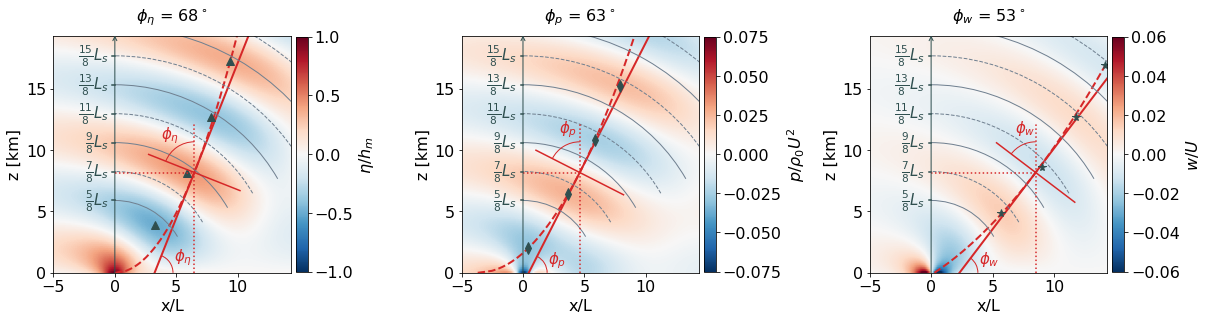

In [21]:
f,ax = plt.subplots(1,3,figsize=(19.2,4.8))
f.subplots_adjust(wspace=0.6)

ann_color = plt.cm.tab10(3)

def plot_2Dcontour(index,variable,name,vmax,xp,zp,symbol,fit_dof,clabel,z1=None):
    # Plot 2D contour of variable
    im=ax[index].imshow(variable.T,
             origin='lower',
             extent=[xs[0]/L, xs[-1]/L, zs[0]/L, zs[-1]/L],
             aspect='equal',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-vmax,vmax=vmax))
    
    # Figure mark-up
    _ = ax[index].set(xlim=[-5,-5+2.05*Ls/L],ylim=[0,2.05*Ls/L],xlabel='x/L',ylabel='z [km]')
    
    # Plot extrema
    ax[index].plot(xp/L,zp/L,symbol,ms=8,color='darkslategrey',zorder=1)
    
    # Height of first maximum where inclination is calculated
    if z1 is None:
        R = np.sqrt(xp**2+zp**2)
        # The value 9/8 works for eta, first maximum of w appears closer to 7/8, not sure for p
        idx = (np.abs(R - 9/8*Ls)).argmin()
        z1 = zp[idx]
        
    if fit_dof == 1:
        # Quadratic fit through zero (x = f(z) )
        b = parabolic_slope_fz(xp, zp)
        ax[index].plot(b*np.sqrt(zs)/L,zs/L,'--',c=ann_color,lw=2,zorder=0)
        
        # Slope at height z1 of quadratic fit through zero
        # (z coordinate of true maximum, x coordinate from quadratic fit through zero)
        # Based on x = f(z)
        x1 = b*np.sqrt(z1)
        bprime = linear_slope_fz(z1,b)
    
    elif fit_dof == 3:
        # Quadratic fit 3 dof (x = b0*sqrt(z-z0)+b1)
        b0, b1, z0 = parabolic_slope_fz_3dof(xp, zp)
        ax[index].plot((b0*np.sqrt(zs-z0)+b1)/L,zs/L,'--',c=ann_color,lw=2,zorder=0)
        
        # Based on x = b0*sqrt(z-z0)+b1
        x1 = b0*np.sqrt(z1-z0)+b1
        bprime = linear_slope_fz_3dof(z1,b0,z0)
    
    # Plot linear fit
    ax[index].plot((bprime*(zs-z1)+x1)/L,zs/L,c=ann_color,lw=2,zorder=0)
    
    # Inclination angle
    phi = np.arctan2(1,bprime)
    
    # Circular wave fronts
    for n in range(1,15):
        radius = (1+4*n)/8*Ls
        ax[index].add_patch(Arc((0,0),2*radius/L,2*radius/L,theta1=30,theta2=90,color='slategrey',linestyle='-'))
        ax[index].plot([-0.2,0],[radius/L,radius/L],color='darkslategrey')
        ax[index].annotate(r'$\frac{{{}}}{{8}}L_s$'.format(1+4*n),xy=(-0.5,radius/L),fontsize=15,color='darkslategrey',
                      ha='right',va='center')
        radius = (3+4*n)/8*Ls
        ax[index].add_patch(Arc((0,0),2*radius/L,2*radius/L,theta1=30,theta2=90,color='slategrey',linestyle='--'))
        ax[index].plot([-0.2,0],[radius/L,radius/L],color='darkslategrey')
        ax[index].annotate(r'$\frac{{{}}}{{8}}L_s$'.format(3+4*n),xy=(-0.5,radius/L),fontsize=15,color='darkslategrey',
                      ha='right',va='center')
    
    ax[index].annotate("", xy=(0, 0), xytext=(0, 2.05*Ls/L),
                       arrowprops=dict(arrowstyle="<-",shrinkA=0,shrinkB=0,color='darkslategrey'))
    ax[index].plot([0,x1/L],[z1/L,z1/L],linestyle=':',color=ann_color)
    
    # Annotations
    ax[index].add_patch(Arc(((x1-bprime*z1)/L,0),3,3,theta1=0,theta2=np.rad2deg(phi),color=ann_color,linestyle='-'))
    ax[index].plot([x1/L-4*np.sin(phi),x1/L+4*np.sin(phi)],[z1/L+4*np.cos(phi),z1/L-4*np.cos(phi)],
               color=ann_color,linestyle='-')
    ax[index].plot([x1/L,x1/L],[0,z1/L+4],color=ann_color,linestyle=':')
    ax[index].add_patch(Arc((x1/L,z1/L),5,5,theta1=90,theta2=90+np.rad2deg(phi),color=ann_color,linestyle='-'))

    cbar = f.colorbar(im,ax=ax[index],shrink=0.9,fraction=0.05, pad=0.02,label=clabel)
                     #ticks=[-1,-.5,0,.5,1])

    title = name+r' = {:2.0f}$^\circ$'.format(np.rad2deg(phi))
    _ = ax[index].set_title(title,pad=15,fontsize=16)
    
    return x1, z1, bprime

# Plot eta
x1, z1, bprime = plot_2Dcontour(0,eta/(0.1*L),r'$\phi_\eta$',1,xp_e,zp_e,symbol='^',fit_dof=1,clabel=r'$\eta/h_m$')

_ = ax[0].annotate(r'$\phi_\eta$', xy=((x1-bprime*z1)/L+1.6,1),fontsize=15,color=ann_color)
_ = ax[0].annotate(r'$\phi_\eta$', xy=(x1/L-2.75,z1/L+2.75),fontsize=15,color=ann_color)

# Plot p
x1, z1, bprime  = plot_2Dcontour(1,p/U**2,r'$\phi_p$',0.075001,xp_p,zp_p,symbol='d',fit_dof=3,
                                 clabel=r'$p/\rho_0 U^2$',z1=z1)

_ = ax[1].annotate("$\phi_p$", xy=((x1-bprime*z1)/L+1.6,.75),fontsize=15,color=ann_color)
_ = ax[1].annotate("$\phi_p$", xy=(x1/L-1.7,z1/L+3.25),fontsize=15,color=ann_color)

# Plot w
x1, z1, bprime  = plot_2Dcontour(2,w/U,r'$\phi_w$',0.06,xp_w,zp_w,symbol='*',fit_dof=3,clabel=r'$w/U$',z1=z1)

_ = ax[2].annotate("$\phi_w$", xy=((x1-bprime*z1)/L+1.6,.75),fontsize=15,color=ann_color)
_ = ax[2].annotate("$\phi_w$", xy=(x1/L-1.7,z1/L+3.25),fontsize=15,color=ann_color)

plt.savefig(os.path.join('Figures','inclination_algorithm.png'),bbox_inches='tight')
plt.savefig(os.path.join('Figures','inclination_algorithm.pdf'),bbox_inches='tight')

# Figure 9

In [63]:
# Input data
N = 0.01 # [1/s]
L = 1000 # [m]

In [64]:
Fr = np.linspace(0,2,81)
Fr = Fr[1:]
Fr = np.array([0.001]+[i for i in Fr])

U = Fr*N*L

In [65]:
%%time
Np_e = np.zeros(Fr.size)
Np_w = np.zeros(Fr.size)
Np_p = np.zeros(Fr.size)
phi_e = np.zeros(Fr.size)
phi_w = np.zeros(Fr.size)
phi_p = np.zeros(Fr.size)
for i, Ui in enumerate(U):
    Np_e[i], phi_e[i], z1 = find_inclination_eta(Ui,N,L,0)
    Np_w[i], phi_w[i] = find_inclination_w(Ui,N,L,0,z1=z1)
    Np_p[i], phi_p[i] = find_inclination_p(Ui,N,L,0,z1=z1)
    
#CPU times: user 2min 5s, sys: 6.44 s, total: 2min 11s
#Wall time: 1min 32s

CPU times: user 2min 3s, sys: 6.59 s, total: 2min 10s
Wall time: 1min 36s


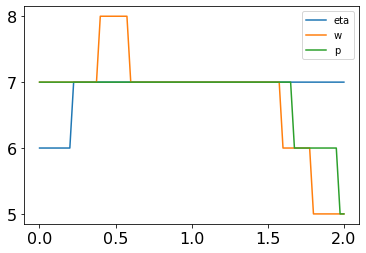

In [66]:
plt.plot(Fr,Np_e,label='eta')
plt.plot(Fr,Np_w,label='w')
plt.plot(Fr,Np_p,label='p')
plt.legend()

In [67]:
# Replace nan by linear interpolation
phi_p_interp = np.interp(np.arange(len(phi_p)), 
                         np.arange(len(phi_p))[np.isnan(phi_p) == False], 
                         phi_p[np.isnan(phi_p) == False])

# Visualization

In [68]:
def fit_func(x, a,b):
    # Curve fitting function
    #return (np.pi/2-b)*np.exp(-a*x)+b
    return b*np.pi*np.exp(-a*x)+(0.5-b)*np.pi

Inclination for Fr going to infinity approaches 64.31841300411965 degrees


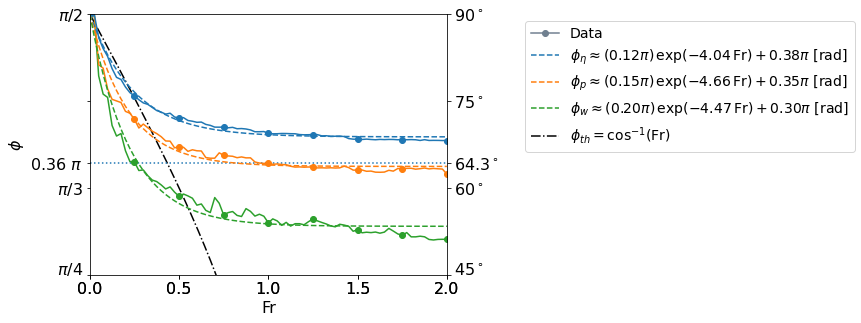

In [69]:
fig=plt.figure(figsize=(6.4,4.8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(Fr,phi_e,'-o',markersize=6,markevery=10,zorder=2)
ax.plot(Fr,phi_p_interp,'-o',markersize=6,markevery=10,zorder=1)
ax.plot(Fr,phi_w,'-o',markersize=6,markevery=10,zorder=0)
#ax.plot(Fr,uniform_filter1d(np.rad2deg(phi_w),size=4,mode='nearest'),'-o',markevery=10,label=r'$\phi_w$',zorder=0)

params = curve_fit(fit_func, Fr, phi_e)
ax.plot(Fr,fit_func(Fr,params[0][0],params[0][1]),'--',c=plt.cm.tab10(0),
       #label=r'$\phi_\eta \approx \left(\frac{{\pi}}{{2}}-{:3.2f}\right)\,\exp(-{:3.2f}\,\mathrm{{Fr}})+{:3.2f}$'.format(params[0][1],params[0][0],params[0][1])+' [rad]')
        label=r'$\phi_\eta \approx \left({:3.2f}\pi\right)\,\exp(-{:3.2f}\,\mathrm{{Fr}})+{:3.2f}\pi$'.format(params[0][1],params[0][0],0.5-params[0][1])+' [rad]')
#print('Fitting function 1: phi_e=(pi/2-{:3.2f})*exp(-{:3.2f}*Fr)+{:3.2f}'.format(params[0][1],params[0][0],params[0][1]))

params = curve_fit(fit_func, Fr, phi_p_interp)
ax.plot(Fr,fit_func(Fr,params[0][0],params[0][1]),'--',c=plt.cm.tab10(1),
       #label=r'$\phi_p \approx \left(\frac{{\pi}}{{2}}-{:3.2f}\right)\,\exp(-{:3.2f}\,\mathrm{{Fr}})+{:3.2f}$'.format(params[0][1],params[0][0],params[0][1])+' [rad]')
        label=r'$\phi_p \approx \left({:3.2f}\pi\right)\,\exp(-{:3.2f}\,\mathrm{{Fr}})+{:3.2f}\pi$'.format(params[0][1],params[0][0],0.5-params[0][1])+' [rad]')
#print('Fitting function 2: phi_p=(pi/2-{:3.2f})*exp(-{:3.2f}*Fr)+{:3.2f}'.format(params[0][1],params[0][0],params[0][1]))

params = curve_fit(fit_func, Fr, phi_w)
ax.plot(Fr,fit_func(Fr,params[0][0],params[0][1]),'--',c=plt.cm.tab10(2),
       #label=r'$\phi_w \approx \left(\frac{{\pi}}{{2}}-{:3.2f}\right)\,\exp(-{:3.2f}\,\mathrm{{Fr}})+{:3.2f}$'.format(params[0][1],params[0][0],params[0][1])+' [rad]')
        label=r'$\phi_w \approx \left({:3.2f}\pi\right)\,\exp(-{:3.2f}\,\mathrm{{Fr}})+{:3.2f}\pi$'.format(params[0][1],params[0][0],0.5-params[0][1])+' [rad]')
#print('Fitting function 3: phi_w=(pi/2-{:3.2f})*exp(-{:3.2f}*Fr)+{:3.2f}'.format(params[0][1],params[0][0],params[0][1]))

# Result from simple linear theory
Frs = np.linspace(0,1,1001)
ax.plot(Frs,np.arccos(Frs),'-.k',zorder=-1,label=r'$\phi_{th}=\cos^{-1}(\mathrm{Fr})$')

# Asymptote for Fr going to infinity
beta = 9
phi_inf = np.arctan(np.sqrt(2/3*(np.sqrt(9+beta**2)-3)))
print('Inclination for Fr going to infinity approaches {} degrees'.format(np.rad2deg(phi_inf)))
ax.axhline(phi_inf,color=plt.cm.tab10(0),linestyle=':',zorder=-1)

#_ = ax.set(ylim=[0,np.pi/2+0.01],xlim=[0,2],xlabel='Fr',ylabel=r'$\phi$ [rad]',
#           yticks=[0,np.pi/6,np.pi/3,phi_inf,np.pi/2],
#           yticklabels=['0',r'$\pi/6$',r'$\pi$/3','{:3.2f}'.format(phi_inf/np.pi)+r' $\pi$',r'$\pi/2$'])
#ax.yaxis.get_majorticklabels()[2].set_verticalalignment('top')
#ax.yaxis.get_majorticklabels()[3].set_verticalalignment('baseline')
_ = ax.set(ylim=[np.pi/4,np.pi/2],xlim=[0,2],xlabel='Fr',ylabel=r'$\phi$',
           yticks=[np.pi/4,np.pi/3,phi_inf,5*np.pi/12,np.pi/2],
           yticklabels=[r'$\pi/4$',r'$\pi$/3','{:3.2f}'.format(phi_inf/np.pi)+r' $\pi$','',r'$\pi/2$'])
ax.yaxis.get_majorticklabels()[0].set_verticalalignment('baseline')

ax2.yaxis.tick_right()
_ = ax2.set(ylim=[45,90],xlim=[0,2],
           yticks=[45,60,np.rad2deg(phi_inf),75,90],
           yticklabels=[r'$45^\circ$',r'$60^\circ$',r'${:3.1f}^\circ$'.format(np.rad2deg(phi_inf)),r'$75^\circ$',r'$90^\circ$'])
ax2.yaxis.set_label_position('right')
ax2.yaxis.get_majorticklabels()[0].set_verticalalignment('baseline')

# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# create manual symbols for legend
from matplotlib.lines import Line2D 
line = Line2D([0], [0], marker='o',label='Data', color='slategrey')
# add manual symbols to auto legend
handles.insert(0,line)

ax.legend(handles=handles,fontsize=14,loc='upper left',bbox_to_anchor=(1.2, 1.0))

plt.savefig(os.path.join('Figures','inclination_vs_Fr.png'),bbox_inches='tight')
plt.savefig(os.path.join('Figures','inclination_vs_Fr.pdf'),bbox_inches='tight')

In [70]:
0.02*180

3.6

In [74]:
Fr=2.2
N=0.01
L=1000
U=Fr*N*L
_, phi, _ = find_inclination_eta(U,N,L,2)
np.rad2deg(phi)

Number of vertical levels is 211 
Horizontal grid resolution is 100.0 m
Vertical grid resolution is 230.38346126325152 m
Number of peaks found is 9
Peak coordinates:
5000.0 5529.203070318036
8700.0 11979.93998568908
11500.0 18661.060362323373
34900.0 25111.797277694415
13900.0 25342.180738957668
16100.0 32023.30111559196
41600.0 38704.421492226254
17900.0 38934.8049534895
19900.0 45615.9253301238


60.89009397471017